In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

c:\Users\Brian Silva\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LightGBM_results = pd.read_excel('LightGBM_results.xlsx')
LSTM_results = pd.read_excel('LSTM_results.xlsx')
Prophet_results = pd.read_excel('Prophet_results.xlsx')
SARIMA_results = pd.read_excel('SARIMA_results.xlsx')
XGBoost_results = pd.read_excel('XGBoost_results.xlsx')

In [3]:
LSTM_results.head()

,Product_ID,Actual,Predicted
0,0,43.0,73.878387
1,0,40.0,75.626968
2,0,58.0,76.696861
3,0,77.0,77.416077
4,0,101.0,77.810112


In [4]:
lightgbm_forecasts = LightGBM_results['predicted']
xgboost_forecasts = XGBoost_results['predicted']
sarima_forecasts = SARIMA_results['predicted']
prophet_forecasts = Prophet_results['predicted_sales']
LSTM_forecasts = LSTM_results['Predicted']

In [5]:
dataset = pd.DataFrame({
    'LightGBM': lightgbm_forecasts,
    'XGBoost': xgboost_forecasts,
    'SARIMA': sarima_forecasts,
    'LSTM': LSTM_forecasts,
    'Prophet': prophet_forecasts,
})

In [73]:
dataset

,LightGBM,XGBoost,SARIMA,LSTM,Prophet
0,52.448424,42.796700,44.514707,73.878387,55.269098
1,52.448424,44.800682,45.329810,75.626968,55.826356
2,64.017135,70.455383,63.785927,76.696861,76.044992
3,70.822538,82.684242,80.570514,77.416077,99.096771
4,54.209002,57.409145,74.025346,77.810112,91.928165
...,...,...,...,...,...
53995,6.256125,12.558356,9.244288,4.058415,9.423506
53996,6.256125,13.917460,10.111103,4.151223,10.128430
53997,7.296950,15.829961,11.487004,4.265136,12.265680
53998,7.655258,17.387810,12.740659,4.366721,13.601703


In [6]:
X_gating = np.vstack((dataset['LightGBM'], dataset['XGBoost'], dataset['SARIMA'], dataset['Prophet'], dataset['LSTM'])).T

# Normalize the data for the neural network
scaler = MinMaxScaler()
X_gating = scaler.fit_transform(X_gating)

In [7]:
model_gating = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')  # Outputs weights for 5 experts
])

model_gating.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model_gating.fit(X_gating, tf.keras.utils.to_categorical(np.argmax(X_gating, axis=1)), callbacks=[early_stopping])

1688/1688 [==============================] - 3s 1ms/step - loss: 0.6513 - accuracy: 0.8114


In [8]:
LightGBM_results_28 = pd.read_excel('LightGBM_results_28.xlsx')
LSTM_results_28 = pd.read_excel('LSTM_results_28.xlsx')
Prophet_results_28 = pd.read_excel('Prophet_results_28.xlsx')
SARIMA_results_28 = pd.read_excel('SARIMA_results_28.xlsx')
XGBoost_results_28 = pd.read_excel('XGBoost_results_28.xlsx')

In [9]:
LightGBM_predicted = LightGBM_results_28['predicted_sales']
LSTM_predicted = LSTM_results_28['Predicted']
SARIMA_predicted = SARIMA_results_28['predicted']
XGBoost_predicted = XGBoost_results_28['predicted']
Prophet_predicted = Prophet_results_28['yhat']

In [10]:
input_for_gating = scaler.transform(np.vstack((LightGBM_predicted, XGBoost_predicted, SARIMA_predicted, Prophet_predicted, LSTM_predicted)).T)
weights = model_gating.predict(input_for_gating)

final_prediction = weights[:, 0] * LightGBM_predicted + weights[:, 1] * XGBoost_predicted + weights[:, 2] * SARIMA_predicted + weights[:, 3] * Prophet_predicted + weights[:, 4] * LSTM_predicted

263/263 [==============================] - 0s 877us/step


In [11]:
final_prediction.values

array([34.12994771, 34.46981052, 32.40110665, ..., 14.64363994,
       15.96041757, 14.94924797])

In [18]:
results_df = pd.DataFrame({
    'date': LightGBM_results_28['date'],
    'product_id': LightGBM_results_28['item_id'],
    'actual': LightGBM_results_28['actual'],
    'predicted': final_prediction.values
})

In [16]:
results_df.dropna(inplace=True)

In [17]:
mae = mean_absolute_error(results_df['actual'], results_df['predicted'])
print('Mean Absolute Error:', mae)

mse = mean_squared_error(results_df['actual'], results_df['predicted'])

mse = mean_squared_error(results_df['actual'], results_df['predicted'])
rmse = sqrt(mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 4.339295661890322
Root Mean Squared Error: 7.007852838008901


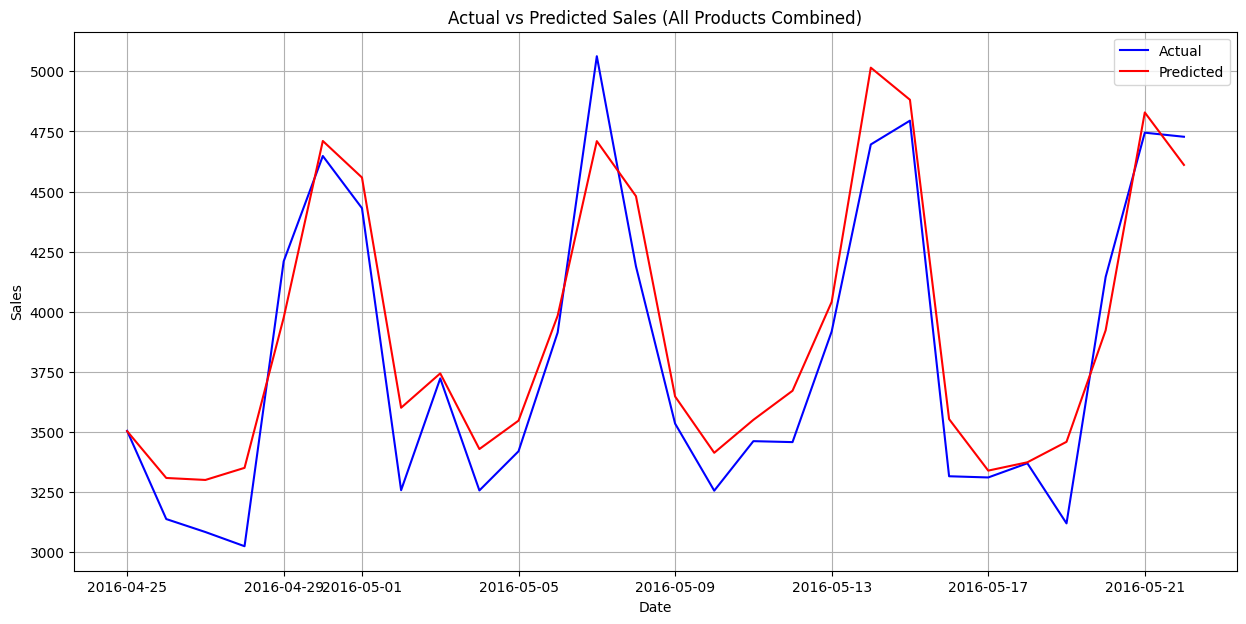

In [109]:
plt.figure(figsize=(15, 7))

results_df['date'] = pd.to_datetime(results_df['date'])

grouped = results_df.groupby('date').agg({
    'actual': 'sum',
    'predicted': 'sum'
}).reset_index()

plt.plot(grouped['date'], grouped['actual'], label='Actual', color='blue')
plt.plot(grouped['date'], grouped['predicted'], label='Predicted', color='red')

plt.legend() 
plt.xlabel('Date') 
plt.ylabel('Sales') 
plt.title('Actual vs Predicted Sales (All Products Combined)') 


plt.grid(True)
plt.show()

In [20]:
results_df.to_excel('ensemble_MoE.xlsx')